Installing dependencies

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install -y python-numpy python-dev cmake zlib1g-dev libjpeg-dev xvfb ffmpeg xorg-dev python-opengl libboost-all-dev libsdl2-dev swig
!pip install pyglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cmake is already the newest version (3.10.2-1ubuntu2).
libjpeg-dev is already the newest version (8c-2ubuntu8).
python-dev is already the newest version (2.7.15~rc1-1).
python-numpy is already the newest version (1:1.13.3-2ubuntu1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libboost-all-dev is already the newest version (1.65.1.0ubuntu1).
python-opengl is already the newest version (3.1.0+dfsg-1).
swig is already the newest version (3.0.12-1).
xorg-dev is already the newest version (1:7.7+19ubuntu7.1).
ffmpeg is already the newest version (7:3.4.6-0ubuntu0.18.04.1).
libsdl2-dev is already the newest version (2.0.8+dfsg1-1ubuntu1.18.04.3).
xvfb is already the newest version (2:1.19.6-1ubuntu4.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to rem

These dependencies are for Pacman, but we probably need these for any atari game, so I'm installing them nonetheless.

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install h5py pyyaml
!pip install tf_nightly

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


Imports

In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

#saving video
from google.colab import files

# CRITICAL FOR TENSOR ORDERING
from keras import backend as K
K.set_image_dim_ordering('th')

from IPython import display as ipythondisplay
from pyvirtualdisplay import Display

# # This code creates a virtual display to draw game images on. 
# # If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video(i):
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[i]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

DQN Functions

In [0]:
#Pre-processing
def to_grayscale(img):
    return np.mean(img, axis=2).astype(np.uint8)

def downsample(img):
    return img[::2, ::2]

def preprocess(img):
    return to_grayscale(downsample(img))

def transform_reward(reward):
    return np.sign(reward)

def fit_batch(model, start_states, actions, rewards, next_states, is_terminal, gamma=.99):
    """Do one deep Q learning iteration.
    
    Params:
    - model: The DQN
    - gamma: Discount factor (should be 0.99)
    - start_states: numpy array of starting states
    - actions: numpy array of one-hot encoded actions corresponding to the start states
    - rewards: numpy array of rewards corresponding to the start states and actions
    - next_states: numpy array of the resulting states corresponding to the start states and actions
    - is_terminal: numpy boolean array of whether the resulting state is terminal
    
    """
    # First, predict the Q values of the next states. Note how we are passing ones as the mask.
    next_Q_values = model.predict([next_states, np.ones(actions.shape)])
    # The Q values of the terminal states is 0 by definition, so override them
    next_Q_values[is_terminal] = 0
    # The Q values of each start state is the reward + gamma * the max next state Q value
    Q_values = rewards + gamma * np.max(next_Q_values, axis=1)
    # Fit the keras model. Note how we are passing the actions as the mask and multiplying
    # the targets by the actions.
    model.fit(
        [start_states, actions], actions * Q_values[:, None],
        epochs=1, batch_size=len(start_states), verbose=0)
    
    return Q_values

def atari_model(n_actions):
    # We assume a theano backend here, so the "channels" are first.
    ATARI_SHAPE = (4, 105, 80)

    # With the functional API we need to define the inputs.
    frames_input = keras.layers.Input(ATARI_SHAPE, name='frames')
    actions_input = keras.layers.Input((n_actions,), name='mask') 

    # Assuming that the input frames are still encoded from 0 to 255. Transforming to [0, 1].
    normalized = keras.layers.Lambda(lambda x: x / 255.0)(frames_input)
    
    # "The first hidden layer convolves 16 8×8 filters with stride 4 with the input image and applies a rectifier nonlinearity."
    conv_1 = keras.layers.convolutional.Convolution2D(
        16, (8, 8), activation='relu', strides=(4, 4),
    )(normalized)
    # "The second hidden layer convolves 32 4×4 filters with stride 2, again followed by a rectifier nonlinearity."
    conv_2 = keras.layers.convolutional.Convolution2D(
        32, (4, 4), strides=(2, 2), activation='relu'
    )(conv_1)
    # Flattening the second convolutional layer.
    conv_flattened = keras.layers.core.Flatten()(conv_2)
    # "The final hidden layer is fully-connected and consists of 256 rectifier units."
    hidden = keras.layers.Dense(256, activation='relu')(conv_flattened)
    # "The output layer is a fully-connected linear layer with a single output for each valid action."
    output = keras.layers.Dense(n_actions)(hidden)
    # Finally, we multiply the output by the mask!
    filtered_output = keras.layers.multiply([output, actions_input])


    model = keras.models.Model(inputs=[frames_input, actions_input], outputs=filtered_output)
    optimizer = keras.optimizers.RMSprop(lr=0.00025, rho=0.95, epsilon=0.01)
    model.compile(optimizer, loss='mse')
    
    return model
  

#Experience Replay: This is going to be memory-intensive...
#Implement finite memory (ring buffer)
class RingBuf:
    def __init__(self, size):
        # Pro-tip: when implementing a ring buffer, always allocate one extra element,
        # this way, self.start == self.end always means the buffer is EMPTY, whereas
        # if you allocate exactly the right number of elements, it could also mean
        # the buffer is full. This greatly simplifies the rest of the code.
        self.data = [None] * (size + 1)
        self.start = 0
        self.end = 0
        self.full = False
        self.episode = 1
        self.rewards = {}
        self.Qvals = {}
        
    def append(self, element):
        self.data[self.end] = element
        self.end = (self.end + 1) % len(self.data)
        # end == start and yet we just added one element. This means the buffer has one
        # too many element. Remove the first element by incrementing start.
        if self.end == self.start:
            self.start = (self.start + 1) % len(self.data)
            self.full = True
    
    def sample_batch(self, nsamples):
      
      idx = np.random.randint(4, len(memory), nsamples)
      start_states = np.zeros((nsamples, 4, 105, 80))
      actions = np.zeros((nsamples, 4))
      next_states = np.zeros((nsamples, 4, 105, 80))
      rewards = np.zeros((nsamples))
      is_terminal = np.zeros((nsamples))
      
      for i, v in enumerate(idx):
        history = range(1,4)
        for h in history:
          if not self.data[v-h]:
            print("index: {}\t history value: {}".format(v, h))
          ss, _, ns, _, _ = self.data[v-h]
          start_states[i, h] = ss
          next_states[i, h] = ns
        ss, a, ns, r, it = self.data[v]
        start_states[i,0] = ss
        actions[i] = a
        next_states[i,0] = ns
        rewards[i] = r
        is_terminal[i] = it
      
      
      return (start_states, actions, next_states, rewards, is_terminal)
    
        
    def __getitem__(self, idx):
        return self.data[(self.start + idx) % len(self.data)]
    
    def __len__(self):
        if self.end < self.start:
            return self.end + len(self.data) - self.start
        else:
            return self.end - self.start
        
    def __iter__(self):
        for i in range(len(self)):
            yield self[i]
    
    
def get_epsilon_for_iteration(iteration):
    if iteration <= 600000:
        epsilon = 1 - (.9*(-50000+iteration)/600000)
    else:
        epsilon = .1
    return epsilon
 

        
    
def q_iteration(env, model, state, iteration, memory):
  
    if iteration > 50000:
      # Choose epsilon based on the iteration
      epsilon = get_epsilon_for_iteration(iteration)

      # Choose the action 
      if random.random() < epsilon:
          action = env.action_space.sample()
      else:
          # choose best action based on model's policy
          history = np.zeros((1,4,105,80))
          history[0,0] = frame
          for i in range(1,4):
            history[0,i] = memory[memory.end-i][0]
          action = np.argmax(model.predict([history, np.ones((1,env.action_space.n))]))
    else:
      # preload memory with random policy for 50000 iterations
      action = env.action_space.sample()
        
    # Play one game iteration (note: according to the next paper, you should actually play 4 times here)
    new_frame, reward, is_done, _ = env.step(action)
    reward = transform_reward(reward)
    
    # LOG REWARD
    if memory.episode not in memory.rewards:
        memory.rewards[memory.episode] = []
    memory.rewards[memory.episode].append(reward)
    
    if is_done:
        new_frame = env.reset()
        memory.episode += 1
    new_frame = preprocess(new_frame)
    
    # one hot encode action
    targets = np.array(action).reshape(-1)
    action = np.eye(4)[targets]
    
    memory.append((state, action, new_frame, reward, is_done))

    # Sample and fit
    if iteration > 50000:
      batch = memory.sample_batch(32)
      start_states, actions, next_states, rewards, is_terminal = batch
      is_terminal = is_terminal.astype('bool')

      q_values = fit_batch(model, start_states, actions, rewards, next_states, is_terminal)
      memory.Qvals[iteration] = q_values
    
    return new_frame
    

In [0]:
## RUN MODEL

# Create a breakout environment
# Wipe existing video/ directory 
env = wrap_env(gym.make('BreakoutDeterministic-v4'))

# Reset it, returns the starting frame
frame = env.reset()
frame = preprocess(frame)

is_done = False
iteration = 0
memory = RingBuf(size = 1000000)
model = atari_model(env.action_space.n)

max_iter = 600000

while not is_done:

  frame = q_iteration(env, model, frame, iteration, memory)
  
  # Render
#   env.render()
  iteration += 1
  if iteration % 10000 == 0:
    print("Iteration: {}".format(iteration))
  
  is_done = (iteration >= max_iter)
  
  # EPISODES?

# for file in glob.glob("openaigym.video.*.mp4"):
#   files.download(file)

Instructions for updating:
Colocations handled automatically by placer.
Iteration: 10000
Iteration: 20000
Iteration: 30000
Iteration: 40000
Iteration: 50000
Instructions for updating:
Use tf.cast instead.
Iteration: 60000
Iteration: 70000
Iteration: 80000
Iteration: 90000
Iteration: 100000
Iteration: 110000
Iteration: 120000
Iteration: 130000
Iteration: 140000
Iteration: 150000
Iteration: 160000
Iteration: 170000
Iteration: 180000
Iteration: 190000
Iteration: 200000
Iteration: 210000
Iteration: 220000
Iteration: 230000
Iteration: 240000
Iteration: 250000
Iteration: 260000
Iteration: 270000
Iteration: 280000
Iteration: 290000
Iteration: 300000
Iteration: 310000
Iteration: 320000
Iteration: 330000
Iteration: 340000
Iteration: 350000
Iteration: 360000
Iteration: 370000
Iteration: 380000
Iteration: 390000
Iteration: 400000
Iteration: 410000
Iteration: 420000
Iteration: 430000
Iteration: 440000
Iteration: 450000
Iteration: 460000
Iteration: 470000
Iteration: 480000
Iteration: 490000
Iterati

In [0]:
mp4list = glob.glob('video/*.mp4')
print(mp4list)

['video/openaigym.video.1.140.video000000.mp4']


In [0]:
avg_q_vals = pd.DataFrame.from_dict(memory.Qvals, orient = 'index')
avg_q_vals = avg_q_vals.mean(axis=1)
avg_q_vals = pd.DataFrame(avg_q_vals)
avg_q_vals.reset_index(drop=False, inplace = True)
avg_q_vals.rename(columns = {0:"avgQ"}, inplace=True)

In [0]:
avg_q_vals.to_csv("avg_q_vals_breakout60k.csv")
files.download("avg_q_vals_breakout60k.csv")

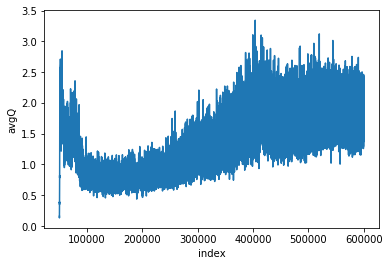

In [0]:
sns.lineplot(x='index',y='avgQ', data=avg_q_vals);
plt.show()

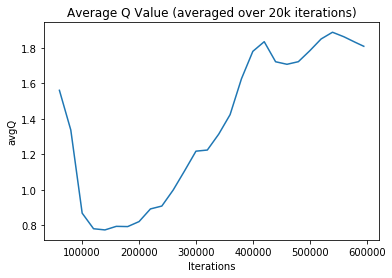

<Figure size 432x288 with 0 Axes>

In [0]:
sns.lineplot(x='index', y='avgQ', data=avg_q_vals.groupby(np.arange(len(avg_q_vals))//20000).mean())
plt.xlabel('Iterations');
plt.title("Average Q Value (averaged over 20k iterations)");
plt.show()
plt.savefig("avgQ.png")
# files.download("avgQ.png")

In [0]:
avg_rewards = {}
for k, v in memory.rewards.items():
  avg_rewards[k] = np.mean(v)
avg_rewards = pd.DataFrame.from_dict(avg_rewards, orient='index')
avg_rewards.reset_index(drop=False, inplace = True)
avg_rewards.rename(columns = {0:"avgReward"}, inplace=True)

[]

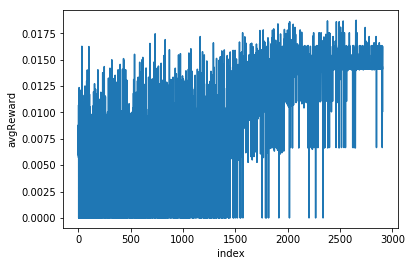

In [0]:
sns.lineplot(x='index',y='avgReward', data=avg_rewards);
plt.plot()

In [0]:
avg_rewards.to_csv("avg_rewards_breakout60k.csv")
files.download("avg_rewards_breakout60k.csv")

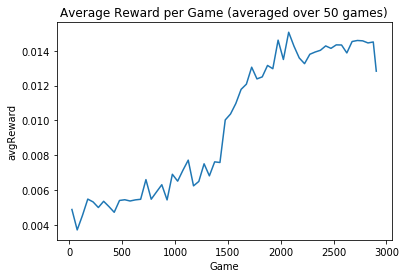

<Figure size 432x288 with 0 Axes>

In [0]:
sns.lineplot(x='index',y='avgReward',data=avg_rewards.groupby(np.arange(len(avg_rewards))//50).mean())
plt.xlabel("Game")
plt.title("Average Reward per Game (averaged over 50 games)")
plt.show()
plt.savefig("avgReward.png")
# files.download("avgReward.png")

In [0]:
total_rewards.to_csv("total_rewards_breakout60k.csv")
files.download("total_rewards_breakout60k.csv")

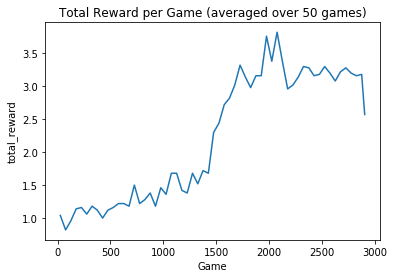

<Figure size 432x288 with 0 Axes>

In [0]:
sns.lineplot(x='index',y='total_reward',data=total_rewards.groupby(np.arange(len(total_rewards))//50).mean())
plt.xlabel("Game")
plt.title("Total Reward per Game (averaged over 50 games)")
plt.show()
plt.savefig("totalReward.png");
files.download("totalReward.png")

In [0]:
# Save entire model to a HDF5 file
model.save('breakout_60k.h5')

In [0]:
files.download("breakout_60k.h5")

In [0]:
# load trained model
new_model = keras.models.load_model('breakout_60k.h5')


In [0]:
show_video(3)

In [0]:
env = wrap_env(gym.make('BreakoutDeterministic-v4'))

observation = env.reset()
iteration = 0
while iteration < 100000:
  
#     env.render()
    if iteration % 10000 == 0:
      print("Iteration {}".format(iteration))
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      _ = env.reset()
    iteration += 1


In [0]:
mp4list = glob.glob('video/*.mp4')
len(mp4list)

12

In [0]:
# TRANSFER LEARNING

observation = env.reset()

env = wrap_env(gym.make('PongDeterministic-v4'))

history = np.zeros((1,4,105,80))
iteration = 0
rewards = []
done=False

while not done:
    
    
    for i in range(3,0, -1):
      history[0,i] = history[0,i-1]
    
    history[0,0] = observation

    if iteration > 3:
      
        action = np.argmax(model.predict([history, np.ones((1,4))]))
    
    else:
        action = env.action_space.sample()
    
    observation, reward, done, _ = env.step(action)
    observation = preprocess(observation)

    reward = transform_reward(reward)
    rewards.append(reward)
        
    
    iteration += 1


In [0]:
mp4list_pong = glob.glob('video/*.mp4')
mp4list_pong

['video/openaigym.video.10.140.video000000.mp4']

In [0]:
# TRANSFER LEARNING

env = wrap_env(gym.make('PongNoFrameskip-v4'))
rewards = []
done=False
_ = env.reset()


while not done:
    action = env.action_space.sample()
    
    observation, reward, done, _ = env.step(action)
    reward = transform_reward(reward)
    rewards.append(reward)
